# Вводная информация об объекте исследования
Вы будете работать с данными, которые собираются с самосвалов, перевозящих породу (например, уголь) на карьере. На самосвалах стоят датчики, которые собирают множество различной информации (скорость, высота, расход топлива и тд). Данные с каждого датчика приходят вместе с временной меткой, идентификатором самосвала и его местоположением (координатами) в момент получения значения с датчика.

Сам по себе карьер состоит из пунктов погрузки (откуда вывозят породу), пунктов разгрузки (куда её отвозят) и маршрутов между ними. На картинке показан пример исходных данных координат самосвалов (синие точки) и примерных дорог на карьере (фиолетовые). Пункты погрузки и разгрузки на картинке не указаны.

Одним рейсом самосвала называется его движение от пункта погрузки до пункта разгрузки и обратно до пункта погрузки.

![](https://drive.google.com/uc?export=view&id=1QLscdUpjOGU8m9WvN8ulKdC9YBWJyKw4)

## Данные:

**telemetry.parquet** - данные телеметрии
* objectid - идентификатор самосвала
* tripid - идентификатор рейса
* driverid - идентификатор водителя
* time - время получения данных с датчиков
* lat, lon - широта и долгота самосвала в текущий момент времени
* x, y, - координаты самосвала на плоскости (https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)
* speed - данные с датчика скорости
* height - высота в текущий момент времени
* engine_speed - обороты двигателя
* fuel_cons - мгновенный расход топлива
* fuel_tank_level - уровень топлива в баке (в процентах)
* weight_dynamic - мгновенное значение веса с датчика (растет, пока самосвал грузит, колеблется вокруг константы, когда едет загруженный и обнуляется при разгрузке и движении без груза обратно на погрузку)
* weight - значение веса груза, который перевез самосвал за текущий рейс (константа для каждого рейса. Даже на той части рейса, где самосвал ехал пустым обратно на погрузку значение этого параметра будет равно весу груза)
* DQ_vertical_bump - вертикальное ускорения
* accelerator_position - позиция педали газа
* w_fl - ?

Пропуски в колонках fuel_tank_level и weight_dynamic обусловлены тем, что эти датчики собираются с меньшей дискретностью (условно, раз в 10 секунд, а не раз в секунду). При необходимости, можно восполнить Nan значения последним определенным значением (т.е. [1, 2, nan, 3, nan, 4, ...] -> [1, 2, 2, 3, 3, 4, ...])

**weather_hourly.parquet** - почасовая погода на карьере. Значения колонок понятны из их названий.

## Задание 1

* Отобразить на графике все местоположения самосвалов из исходных данных (предварительно убрав очевидные выбросы по координатам) = карта карьера (пока некорректная из-за ещё некоторых проблем с координатами)
* Обнаружить самосвал(ы), для которых всё ещё есть проблемы с координатами (обозначить их идентификаторы)
* Понять, по какому параметру можно избавиться от этих выбросов по координатам, и сделать чистку
* Нарисовать корректную карту карьера (если удалость определить, как сделать чистку)
* При необходимости, произвести чистку по другим колонкам (препроцессинг для дальнейшего обучения модели)
* Предположить, что обозначают значения колонки w_fl (путем анализа имеющихся данных) - ответ написать в текстовом поле и обосновать

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
data = pd.read_parquet('telemetry.parquet')

In [75]:
weather = pd.read_parquet('weather_hourly.parquet')

In [4]:
data.head()

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
0,1121,2023-11-08 05:31:31.309000+07:00,63.328824,83.727988,3.00394,195.7,390.00,NaN,99.99,0,0,60.0,216.0,1003671.0,215.0,2891.0,1,636592.202274,7.025133e+06
1,1125,2023-11-08 03:21:39+07:00,63.334962,83.751046,0.00000,280.0,0.00,0.000,8.00,0,0,NaN,NaN,1003657.0,216.0,2887.0,0,637716.857273,7.025866e+06
2,1124,2023-11-08 19:20:55+07:00,63.343592,83.739678,4.20000,228.0,66.85,778.000,5.00,0,0,NaN,NaN,1003798.0,217.0,2875.0,0,637106.943106,7.026803e+06
3,1124,2023-11-08 14:16:39+07:00,63.343290,83.751773,16.80000,278.0,2.45,743.375,6.00,0,0,NaN,NaN,1003749.0,209.0,2875.0,0,637713.403209,7.026795e+06
4,1121,2023-11-08 11:09:49.347000+07:00,63.331924,83.765388,0.00000,70.9,17.00,NaN,99.99,0,0,38.0,0.0,1003728.0,204.0,2894.0,0,638449.084136,7.025559e+06


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426322 entries, 0 to 426321
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype                                
---  ------                --------------   -----                                
 0   objectid              426322 non-null  int64                                
 1   time                  426322 non-null  datetime64[us, pytz.FixedOffset(420)]
 2   lat                   426322 non-null  float64                              
 3   lon                   426322 non-null  float64                              
 4   speed                 426322 non-null  float64                              
 5   height                426322 non-null  float64                              
 6   fuel_cons             426322 non-null  float64                              
 7   engine_speed          259203 non-null  float64                              
 8   hdop                  426322 non-null  float64                  

In [6]:
data.describe()

,objectid,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
count,426322.000000,426322.000000,426322.000000,426322.000000,426322.000000,426322.000000,259203.000000,426322.000000,426322.0,426322.0,167118.000000,167119.000000,4.253670e+05,425367.000000,425367.000000,426322.000000,426322.000000,4.263220e+05
mean,1123.811115,63.334951,83.741407,13.190398,190.954827,100.786711,1099.331509,23.995118,0.0,0.0,47.944135,96.086106,1.003731e+06,213.705264,2890.882269,0.455069,637310.774179,7.025849e+06
std,1.728688,0.306873,0.406129,12.541732,123.947698,128.811076,354.426768,36.951528,0.0,0.0,14.930978,103.151354,6.050815e+01,6.899292,11.518725,0.497978,3259.147072,3.404231e+04
min,1121.000000,0.000000,0.000000,0.000000,-433.400000,0.000000,0.000000,0.610000,0.0,0.0,12.000000,0.000000,1.003626e+06,195.000000,2875.000000,0.000000,0.000000,0.000000e+00
25%,1123.000000,63.334432,83.727788,0.529672,130.300000,17.000000,977.000000,6.000000,0.0,0.0,36.000000,0.000000,1.003678e+06,210.000000,2878.000000,0.000000,636595.910597,7.025806e+06
50%,1124.000000,63.337024,83.750318,11.497200,255.000000,35.350000,1124.750000,7.000000,0.0,0.0,47.000000,2.000000,1.003731e+06,214.000000,2889.000000,0.000000,637670.310177,7.026094e+06
75%,1125.000000,63.341972,83.755314,24.400000,271.000000,145.900000,1293.000000,10.000000,0.0,0.0,59.000000,210.000000,1.003780e+06,219.000000,2902.000000,1.000000,637887.903113,7.026659e+06
max,1126.000000,63.350544,83.789288,50.500000,332.000000,441.900000,1874.000000,99.990000,0.0,0.0,100.000000,249.000000,1.003841e+06,231.000000,2909.000000,1.000000,639639.257576,7.027611e+06


Основными проблемами в данных, которые видны из общего анализа, являются нули в данных координат (широта, долгота, x и y). А также данные высоты, где есть значения ниже нуля и общий перепад высот составляет больше 700 метров.

In [4]:
data_filter = data.loc[(data['x'] != 0) & (data['y'] != 0)]

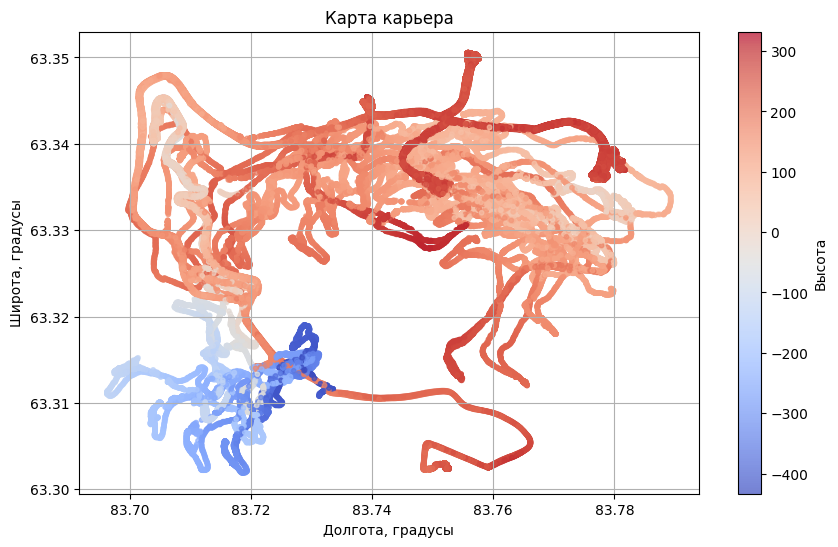

In [38]:
plt.figure(figsize=(10, 6))

sc = plt.scatter(data_filter['lon'], data_filter['lat'], 
                 c=data_filter['height'], cmap='coolwarm', 
                 s=10, alpha=0.7)

cbar = plt.colorbar(sc)
cbar.set_label('Высота')

plt.xlabel('Долгота, градусы')
plt.ylabel('Широта, градусы')
plt.title('Карта карьера')
plt.grid()

plt.show()

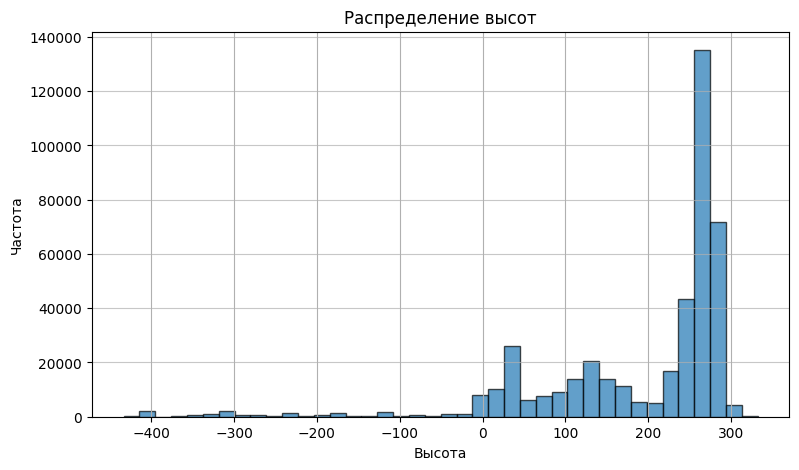

In [60]:
plt.figure(figsize=(9, 5))

data_filter['height'].hist(bins=40, edgecolor='black', alpha=0.7)

plt.title('Распределение высот')
plt.xlabel('Высота')
plt.ylabel('Частота')

plt.grid(axis='y', alpha=0.7)

plt.show()

In [11]:
data_filter.loc[(data_filter['height'] < 0) & (data['engine_speed'].isna()), 'objectid'].unique()

array([1121, 1123])

Логичным кажется удалить значения ниже какого-то значения, но значения изменения высоты достаточно плавные в рамках одной поездки, а не выбросообразные. В общем случае, стоило бы обсудить со специалистами из доменной области (какие значения высоты характерны для данного карьера) или же сравнить значения высот для одних и тех же координат (нужны данные с других грузовиков для тех же точек координат). В виду невозможности применить один из предыдущих методов, отфильтруем эти значения статистическим методом. Наиболее подходящим кажется метод интерквартильного размаха по данным высоты для южной части карьера.

In [27]:
for_stat = data_filter.loc[data_filter['y'] >= 7025000]
q1 = for_stat['height'].quantile(q = 0.25)
q3 = for_stat['height'].quantile(q = 0.75)

iqr = q3 - q1

lower = q1 - 1.5*iqr
higher = q3 + 1.5*iqr
print('Нижняя граница высот', round(lower, 2))
print('Верхняя граница высот', round(higher, 2))

Нижняя граница высот -1.25
Верхняя граница высот 437.55


In [5]:
data_filter = data_filter.loc[data_filter['height'] >= -1.25]

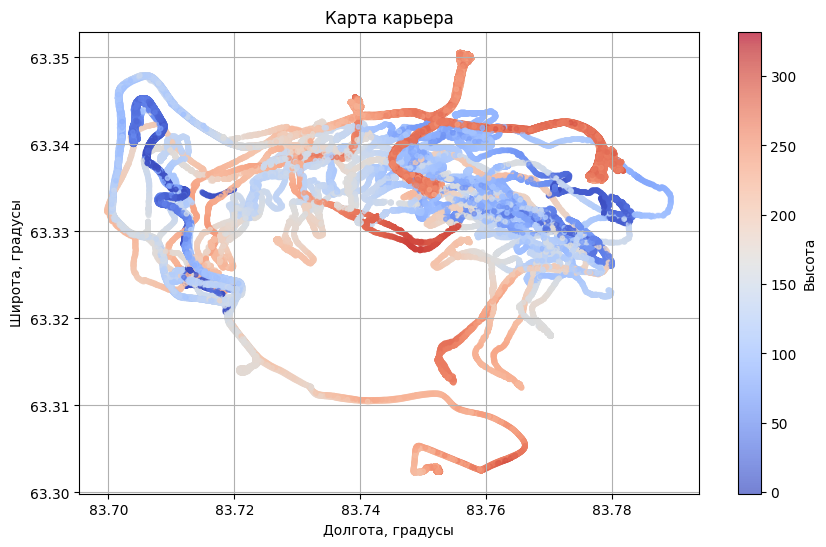

In [40]:
plt.figure(figsize=(10, 6))

sc = plt.scatter(data_filter['lon'], data_filter['lat'], 
                 c=data_filter['height'], cmap='coolwarm', 
                 s=10, alpha=0.7)

cbar = plt.colorbar(sc)
cbar.set_label('Высота')

plt.xlabel('Долгота, градусы')
plt.ylabel('Широта, градусы')
plt.title('Карта карьера')
plt.grid()

plt.show()

In [6]:
data_sorted = data_filter.sort_values(by = ['objectid','time']).reset_index()
data_sorted.head()

,index,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
0,420794,1121,2023-11-08 00:00:00.803000+07:00,63.346624,83.702188,19.4590,132.0,390.0,NaN,4.91,0,0,41.0,209.0,1003626.0,210.0,2891.0,1,635217.355791,7.027060e+06
1,235518,1121,2023-11-08 00:00:01.805000+07:00,63.346724,83.702188,19.9201,132.2,383.0,NaN,4.92,0,0,41.0,209.0,1003626.0,210.0,2891.0,1,635216.886103,7.027072e+06
2,261904,1121,2023-11-08 00:00:02.806000+07:00,63.346824,83.702288,21.2628,132.5,385.0,NaN,4.84,0,0,42.0,209.0,1003626.0,210.0,2891.0,1,635221.418157,7.027083e+06
3,113820,1121,2023-11-08 00:00:03.807000+07:00,63.346824,83.702388,21.6202,132.8,389.0,NaN,4.83,0,0,42.0,209.0,1003626.0,210.0,2891.0,1,635226.419899,7.027083e+06
4,156638,1121,2023-11-08 00:00:04.808000+07:00,63.346924,83.702388,21.3536,133.0,389.0,NaN,8.56,0,0,41.0,209.0,1003626.0,210.0,2891.0,1,635225.950176,7.027094e+06


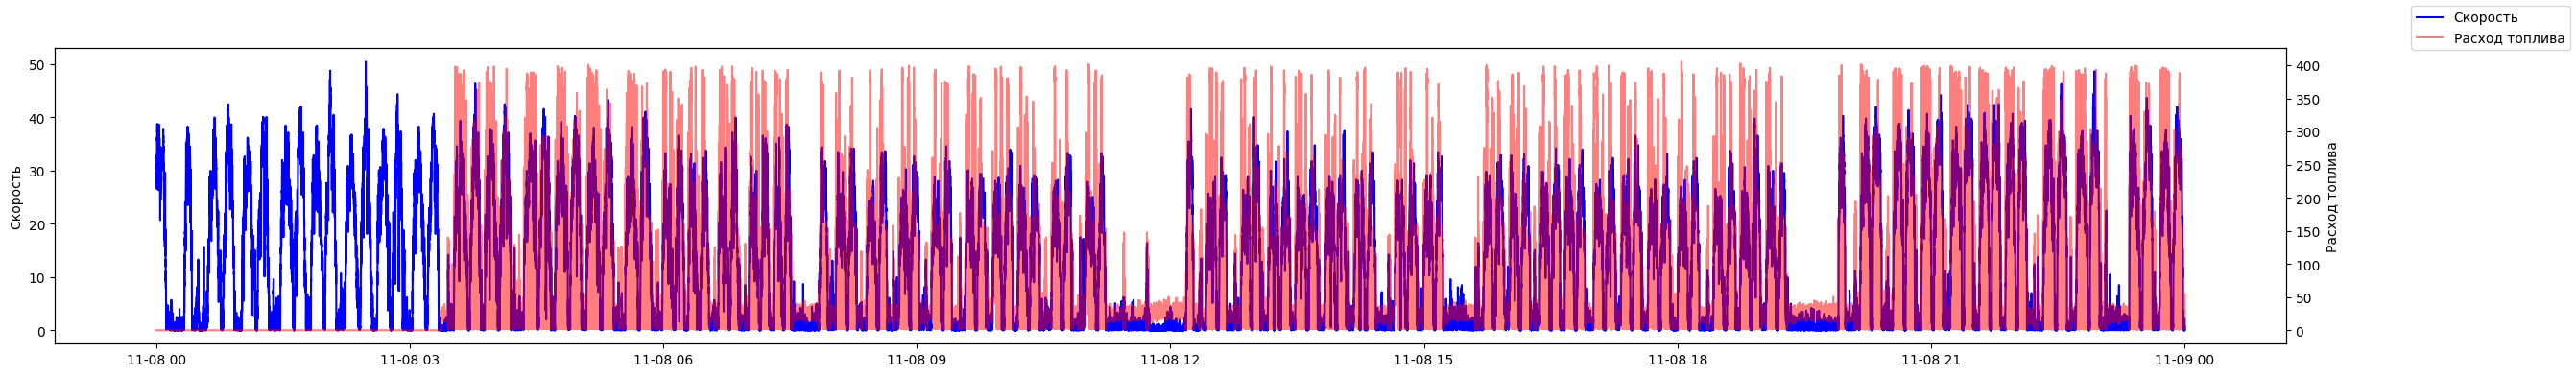

In [30]:
fig, ax1 = plt.subplots(figsize=(30, 4))

ax1.plot(data_sorted.loc[(data_sorted['objectid'] == 1125), 'time'], 
         data_sorted.loc[(data_sorted['objectid'] == 1125), 'speed'], 
         label='Скорость', color='b')
ax1.set_ylabel('Скорость')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(data_sorted.loc[(data_sorted['objectid'] == 1125), 'time'], 
         data_sorted.loc[(data_sorted['objectid'] == 1125), 'fuel_cons'], 
         label='Расход топлива', color='r', alpha=0.5)
ax2.set_ylabel('Расход топлива')
ax2.tick_params(axis='y')

fig.legend(loc="upper right")

plt.show()

Также встречаются интервалы, где расход топлива равен нулю, а скорость грузовика - нет. Такие данные расхода топлива заменены пустыми значениями.

In [7]:
data_sorted.loc[(data_sorted['speed'] != 0) & (data_sorted['fuel_cons'] == 0), 'fuel_cons'] == np.nan
data_sorted.describe()

,index,objectid,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
count,405426.000000,405426.000000,405426.000000,405426.000000,405426.000000,405426.000000,405426.000000,259203.000000,405426.000000,405426.0,405426.0,146222.000000,146223.000000,4.044710e+05,404471.000000,404471.000000,405426.000000,405426.000000,4.054260e+05
mean,213133.666210,1123.938317,63.337422,83.744751,13.210802,210.446455,99.236152,1099.331509,21.138520,0.0,0.0,48.677422,95.658515,1.003727e+06,213.861473,2890.810575,0.452655,637390.132055,7.026127e+06
std,123051.634917,1.668223,0.007430,0.020620,12.556837,86.105728,127.272544,354.426768,34.448489,0.0,0.0,15.442729,103.145332,5.891712e+01,6.901609,11.736120,0.497754,1027.558739,8.343740e+02
min,0.000000,1121.000000,63.302267,83.699788,0.000000,-1.200000,0.000000,0.000000,0.610000,0.0,0.0,12.000000,0.000000,1.003626e+06,195.000000,2875.000000,0.000000,635163.006863,7.022221e+06
25%,106543.250000,1123.000000,63.334604,83.738658,0.538932,144.600000,17.000000,977.000000,6.000000,0.0,0.0,36.000000,0.000000,1.003676e+06,210.000000,2878.000000,0.000000,637066.547528,7.025825e+06
50%,213149.500000,1124.000000,63.337534,83.750849,11.600000,258.000000,35.450000,1124.750000,7.000000,0.0,0.0,49.000000,1.000000,1.003728e+06,214.000000,2889.000000,0.000000,637703.162403,7.026154e+06
75%,319645.750000,1125.000000,63.342120,83.755688,24.400000,272.000000,143.000000,1293.000000,9.000000,0.0,0.0,60.000000,210.000000,1.003771e+06,219.000000,2902.000000,1.000000,637896.862710,7.026669e+06
max,426321.000000,1126.000000,63.350544,83.789288,50.500000,332.000000,441.900000,1874.000000,99.990000,0.0,0.0,100.000000,249.000000,1.003841e+06,231.000000,2909.000000,1.000000,639639.257576,7.027611e+06


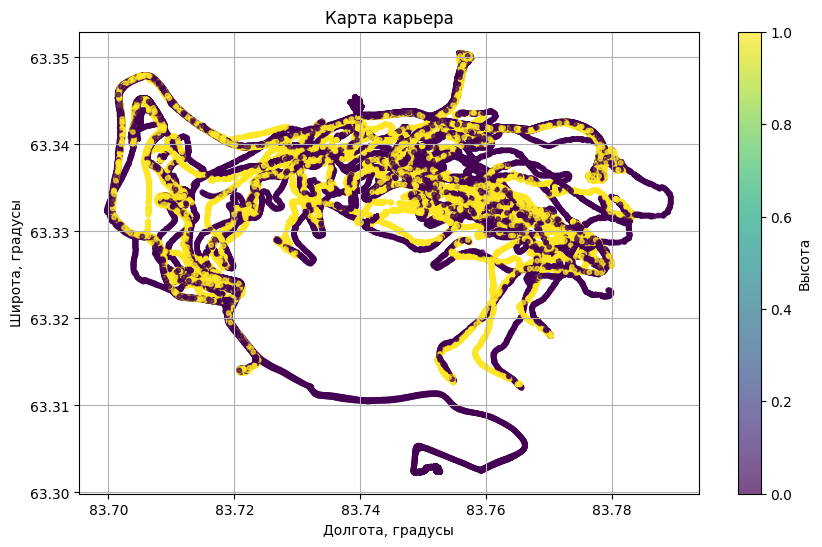

In [77]:
plt.figure(figsize=(10, 6))

sc = plt.scatter(data_filter['lon'], data_filter['lat'], 
                 c=data_filter['w_fl'], 
                 s=10, alpha=0.7)

cbar = plt.colorbar(sc)
cbar.set_label('Высота')

plt.xlabel('Долгота, градусы')
plt.ylabel('Широта, градусы')
plt.title('Карта карьера')
plt.grid()

plt.show()

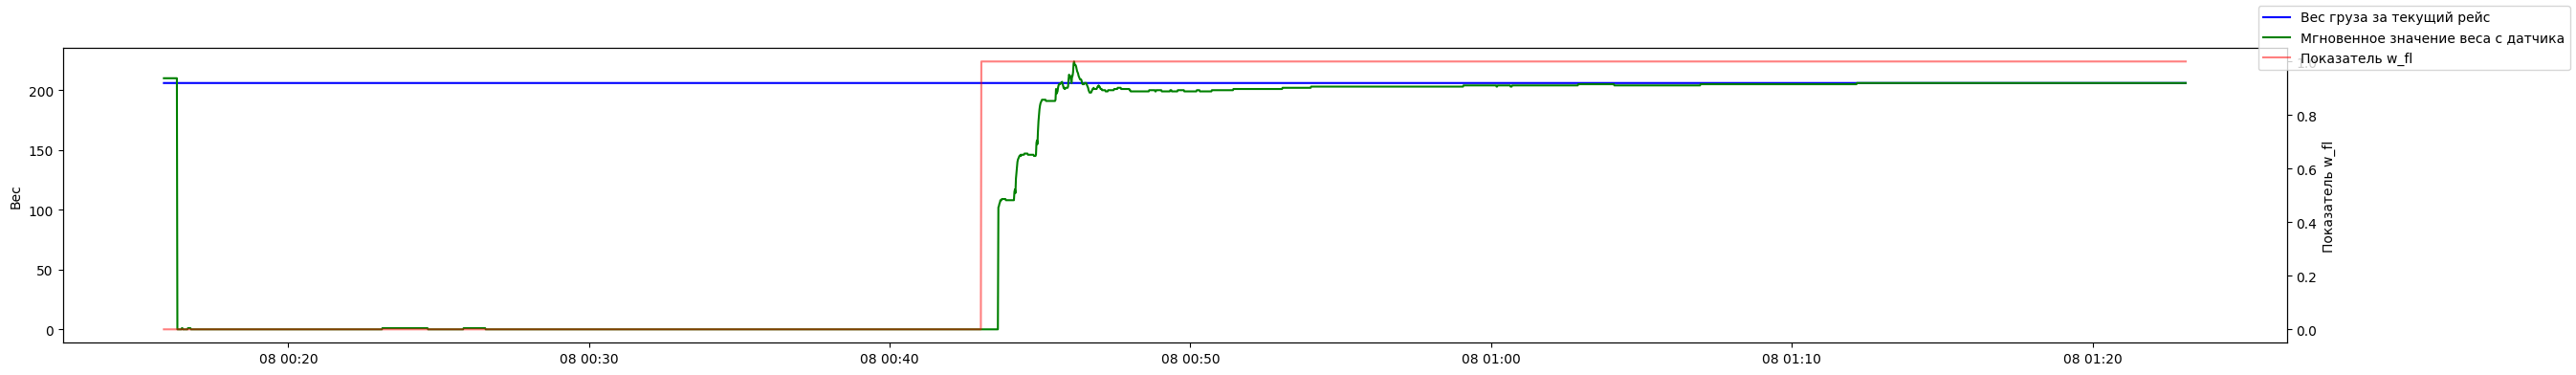

In [43]:
tripid = 1003634.0

fig, ax1 = plt.subplots(figsize=(30, 4))

ax1.plot(data_sorted.loc[(data_sorted['tripid'] == tripid), 'time'],
         data_sorted.loc[(data_sorted['tripid'] == tripid), 'weight'], 
         label='Вес груза за текущий рейс', color='b')
ax1.plot(data_sorted.loc[(data_sorted['tripid'] == tripid), 'time'],
         data_sorted.loc[(data_sorted['tripid'] == tripid), 'weight_dynamic'], 
         label='Мгновенное значение веса с датчика', color='g')
ax1.set_ylabel('Вес')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(data_sorted.loc[(data_sorted['tripid'] == tripid), 'time'],
         data_sorted.loc[(data_sorted['tripid'] == tripid), 'w_fl'], 
         label='Показатель w_fl', color='r', alpha=0.5)
ax2.set_ylabel('Показатель w_fl')
ax2.tick_params(axis='y')

fig.legend(loc="upper right")

plt.show()

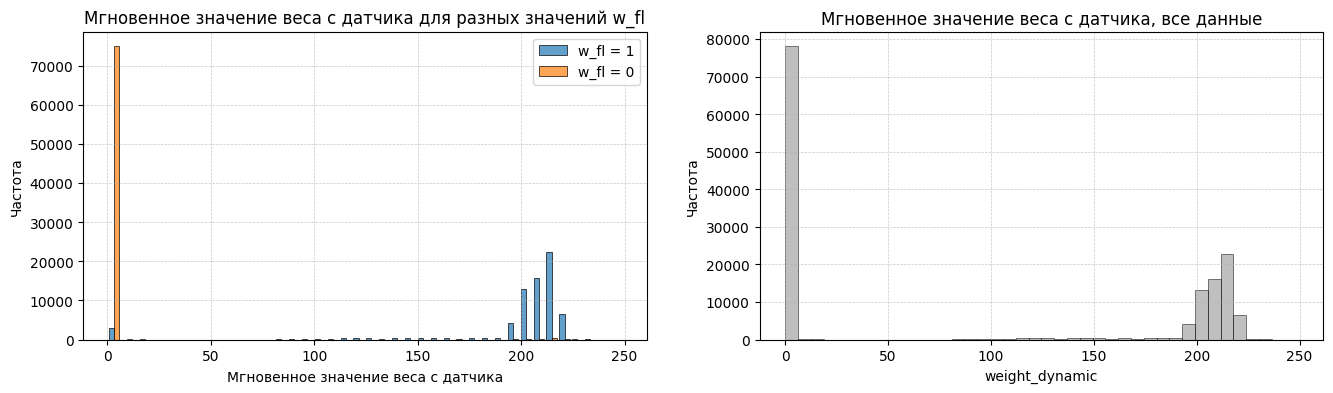

In [49]:
classes = data_sorted['w_fl'].unique()
column = 'weight_dynamic'
list_classes = []

for wfl_class in classes:
    data_column = data_sorted.loc[data_sorted['w_fl'] == wfl_class, column]
    data_column.dropna()
    list_classes.append(data_column)

fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# Histogram by w_fl class with labels
axs[0].hist(list_classes, 40, stacked=False, alpha=0.7, label=[f'w_fl = {c}' for c in classes], edgecolor='black', linewidth=0.7)
axs[0].set_title('Мгновенное значение веса с датчика для разных значений w_fl')
axs[0].set_xlabel('Мгновенное значение веса с датчика')
axs[0].set_ylabel('Частота')
axs[0].legend()
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Histogram for all data
axs[1].hist(data_sorted[column].dropna(), 40, alpha=0.5, color='gray', edgecolor='black', linewidth=0.7)
axs[1].set_title('Мгновенное значение веса с датчика, все данные')
axs[1].set_xlabel(column)
axs[1].set_ylabel('Частота')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

w_fl - показатель того, загружен грузовик или нет. Он достаточно точно совпадает с мгновенным показанием веса с датчика. Различия во времени, скорее всего связаны с разной процедурой сбора этого значения. Скорее всего, значение 1 выставляется перед началом погрузки, когда показания с датчика веса ещё не начали расти. Также на карте карьера видно, что грузовик доезжает до крайней точки на маршруте в карьере, затем показание w_fl меняется и грузовик едет обратно.

## Задание 2

Все пункты делаются на данных, оставшихся после чистки в Задании 1. Правильных ответов (по числам) нет, т к препроцессинг может отличаться. Нам интересно увидеть, как Вы это делаете.
* Вывести средние значения параметров ['hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height'] по самосвалам

In [50]:
objectids = data_sorted['objectid'].unique()

print(f"{'objectid':<10} {'hdop':<10} {'speed':<10} {'engine_speed':<15} {'DQ_vertical_bump':<20} {'height':<10}")

for objectid in objectids:
    data_object = data_sorted.loc[data_sorted['objectid'] == objectid]
    
    hdop_mean = data_object['hdop'].mean()
    speed_mean = data_object['speed'].mean()
    engine_speed_mean = data_object['engine_speed'].mean()
    dq_vertical_bump_mean = data_object['DQ_vertical_bump'].mean()
    height_mean = data_object['height'].mean()
    
    print(f'{objectid:<10} {hdop_mean:<10.2f} {speed_mean:<10.2f} {engine_speed_mean:<15.2f} {dq_vertical_bump_mean:<20.2f} {height_mean:<10.2f}')

objectid   hdop       speed      engine_speed    DQ_vertical_bump     height    
1121       92.26      9.96       nan             0.00                 134.22    
1122       99.99      0.01       nan             0.00                 236.92    
1123       2.50       15.83      nan             0.00                 95.32     
1124       7.04       12.79      1135.72         0.00                 266.99    
1125       8.44       13.72      1000.70         0.00                 264.88    
1126       7.58       13.43      1161.57         0.00                 262.75    


* Построить гистограмму суммарных расстояний за каждый рейс.

In [51]:
tripids = data_sorted['tripid'].unique()

df_list = []

for tripid in tripids:
    data_trip = data_sorted.loc[data_sorted['tripid'] == tripid]

    data_trip[['x_before', 'y_before', 'height_before']] = data_trip[['x', 'y', 'height']].shift(1)
    data_trip['dx2'] = (data_trip['x'] - data_trip['x_before'])**2
    data_trip['dy2'] = (data_trip['y'] - data_trip['y_before'])**2
    data_trip['dz2'] = (data_trip['height'] - data_trip['height_before'])**2
    data_trip[['dx2', 'dy2', 'dz2']] = data_trip[['dx2', 'dy2', 'dz2']].fillna(0)
    data_trip['dist'] = (data_trip['dx2'] + data_trip['dy2'] + data_trip['dz2'])**0.5

    df_list.append(data_trip)

df_dist = pd.concat(df_list)

grouped_dist = df_dist.groupby(by = 'tripid')['dist'].sum()

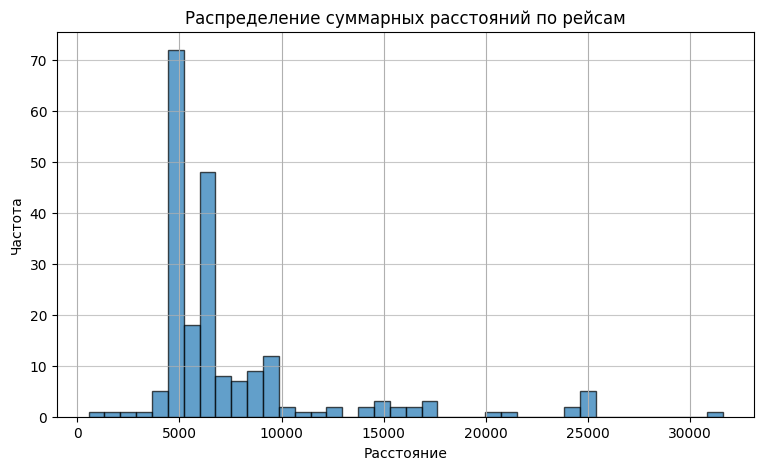

In [63]:
plt.figure(figsize=(9, 5))

grouped_dist.hist(bins=40, edgecolor='black', alpha=0.7)

plt.title('Распределение суммарных расстояний по рейсам')
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.7)

plt.show()

* Вывести таблицу средних скоростей самосвалов за каждый час суток (формат: колонки - час суток, строки - самосвалы, в ячейках - средняя скорость)

Поменяла местами колорки и столбцы для лучшей читаемости данных

In [80]:
data_sorted['day'] = data_sorted['time'].dt.day
data_sorted['hour'] = data_sorted['time'].dt.hour

pd.pivot_table(data_sorted.loc[data_sorted['day'] == 8], index = 'hour', columns = 'objectid', values = 'speed', aggfunc = 'mean')

objectid,1121,1122,1123,1124,1125,1126
hour,,,,,,
0,18.466040,NaN,22.129006,19.359444,13.207333,17.658694
1,12.862556,NaN,17.762304,15.550194,17.689444,18.087889
2,8.235196,NaN,21.258933,17.290861,17.936111,15.322750
3,6.410654,NaN,11.445116,10.585278,16.948139,12.422889
4,13.865112,NaN,21.829279,14.064222,17.857639,17.381333
5,5.952499,NaN,15.330034,12.226444,15.306083,15.643083
6,7.554358,NaN,9.633959,14.285306,13.476444,14.816139
7,4.958597,NaN,11.547280,5.915778,11.308389,6.677806
8,7.181664,NaN,15.087538,11.248639,13.151722,13.042917


* Выбрать по одному рейсу для каждого самосвала. Для каждого рейса: нарисовать его на общей карте карьера, нарисовать на одном графике кривую изменения скорости от времени и высоты от времени (шкалы должны быть на разных осях).

Сейчас в цикле для каждого грузовика (кроме 1122, для него нет данных по индексам поездок) в цикле выбирается случайная поездка и отрисовывается

In [9]:
import warnings
warnings.filterwarnings("ignore")

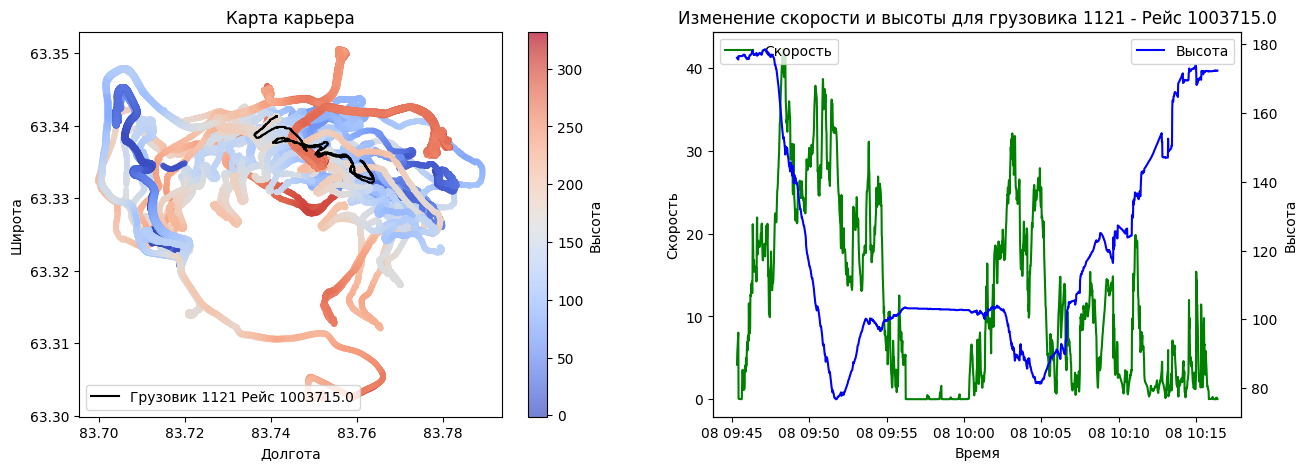

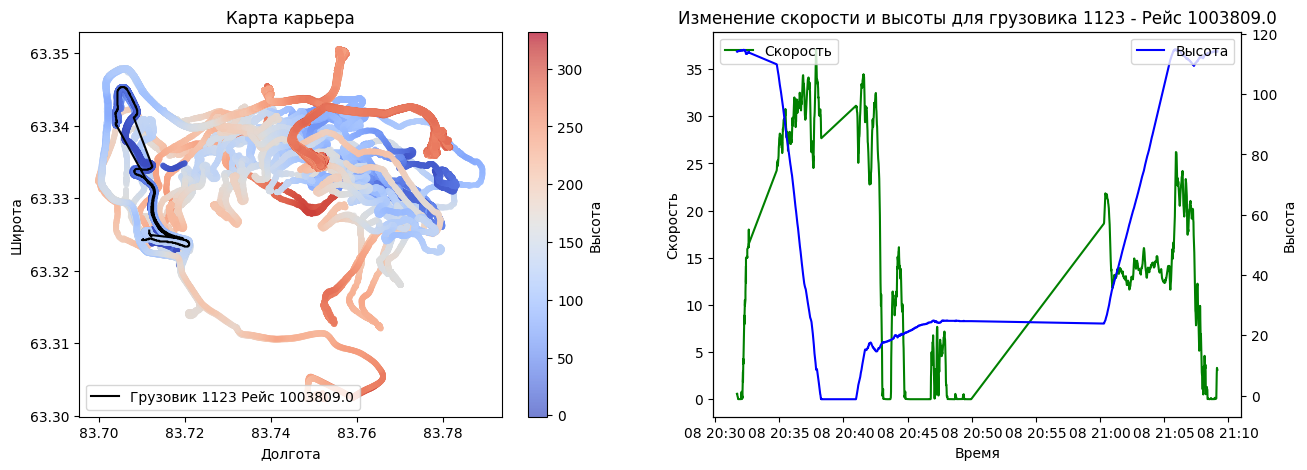

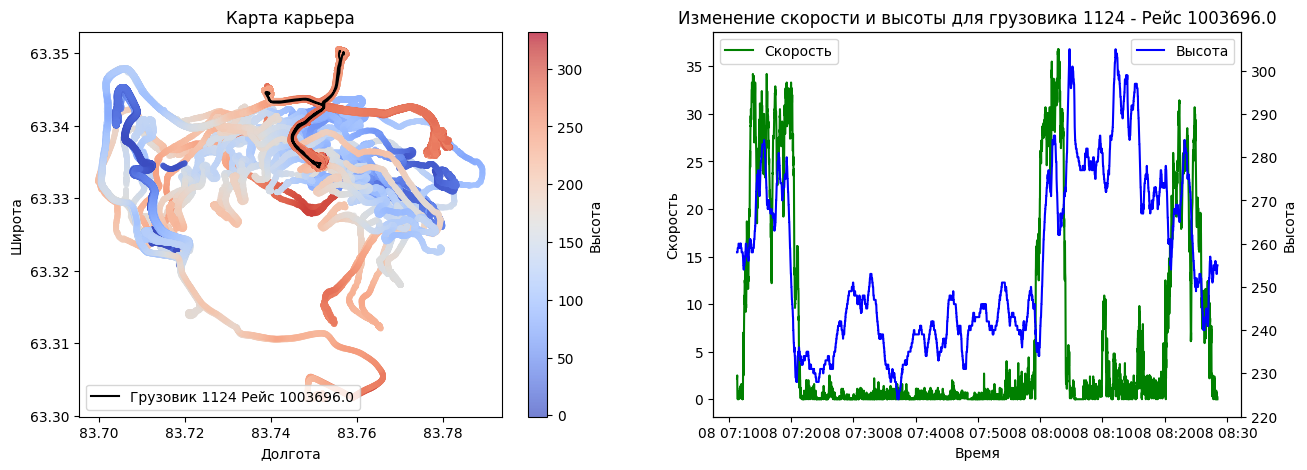

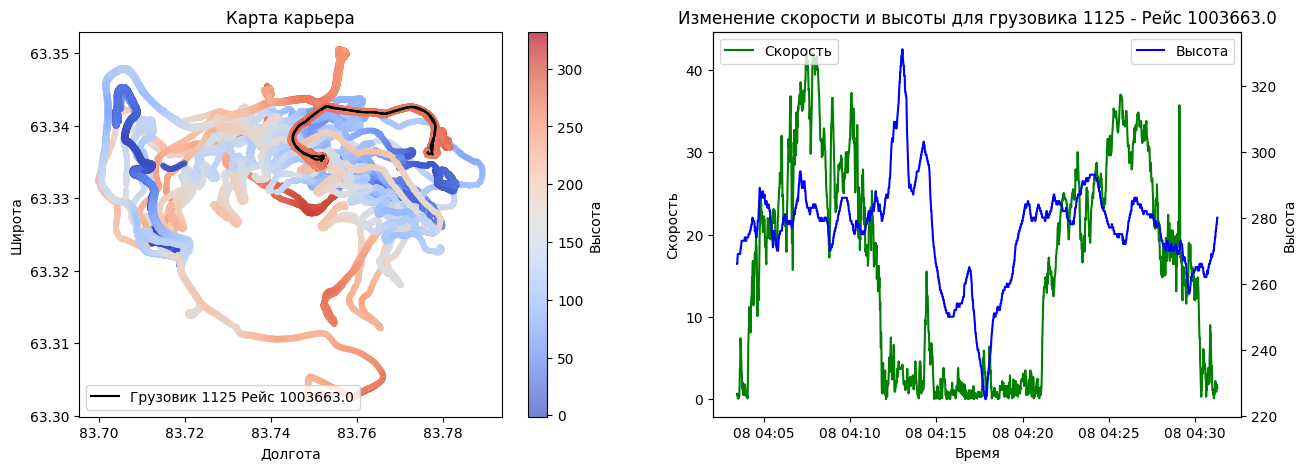

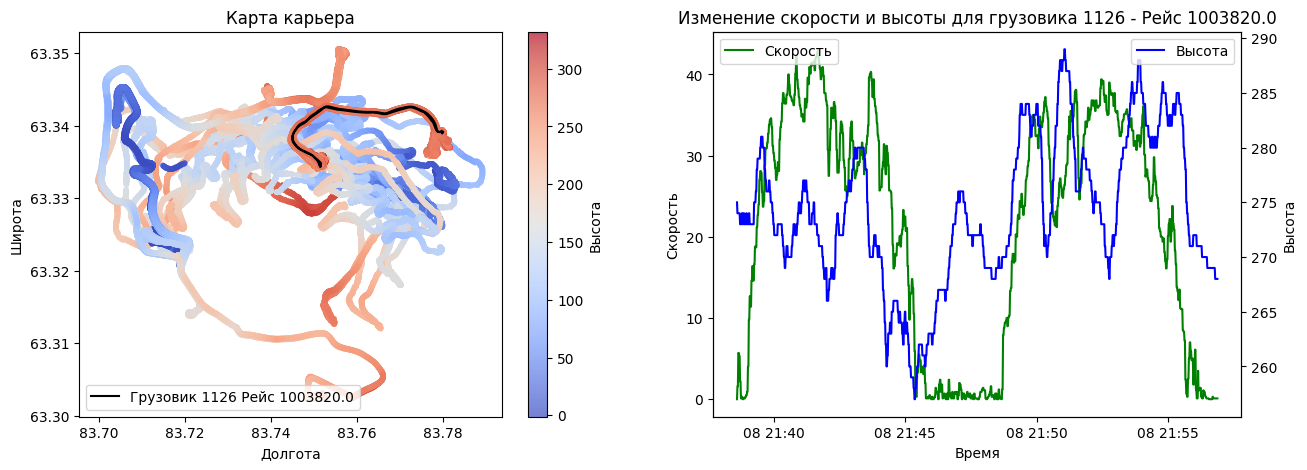

In [10]:
objectids = [1121, 1123, 1124, 1125, 1126]

for objectid in objectids:
    data_object = data_sorted.loc[data_sorted['objectid'] == objectid]
    tripids = list(filter(None, data_object['tripid'].unique()))
    tripid_plot = random.choice(tripids)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    trip_data = data_object[data_object['tripid'] == tripid_plot]
    
    ax0 = axes[0]
    sc = ax0.scatter(data_sorted['lon'], data_sorted['lat'], 
                 c=data_sorted['height'], cmap='coolwarm', 
                 s=10, alpha=0.7)
    ax0.plot(trip_data['lon'], trip_data['lat'], linestyle='-', label=f'Грузовик {objectid} Рейс {tripid_plot}', c = 'black')

    cbar = plt.colorbar(sc)
    cbar.set_label('Высота')

    ax0.set_xlabel('Долгота')
    ax0.set_ylabel('Широта')
    ax0.set_title('Карта карьера')
    ax0.legend()

    ax1 = axes[1]
    ax2 = ax1.twinx()
    
    ax1.plot(trip_data['time'], trip_data['speed'], 'g-', label='Скорость')
    ax2.plot(trip_data['time'], trip_data['height'], 'b-', label='Высота')
    
    ax1.set_xlabel('Время')
    ax1.set_ylabel('Скорость')
    ax2.set_ylabel('Высота')
    ax1.set_title(f'Изменение скорости и высоты для грузовика {objectid} - Рейс {tripid_plot}')
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()

* Присоединить данные погоды к данным телеметрии

In [78]:
weather.head()

,time,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,visibility,precipType,rain,snow,no_weather_info
0,2023-11-07 20:00:00+00:00,0.0,0.0,-13.27,-20.02,-17.59,67.0,1027.0,3.48,8.91,60.0,100.0,10000.0,clouds,0,0,1
1,2023-11-08 06:00:00+00:00,0.0,0.0,-9.27,-15.79,-16.07,54.0,1020.0,4.13,8.20,71.0,100.0,10000.0,clouds,0,0,1
2,2023-11-07 18:00:00+00:00,0.0,0.0,-13.27,-20.10,-17.59,67.0,1028.0,3.55,8.92,62.0,95.0,10000.0,clouds,0,0,1
3,2023-11-07 16:00:00+00:00,0.0,0.0,-13.27,-19.67,-17.44,68.0,1030.0,3.18,7.71,61.0,94.0,10000.0,clouds,0,0,1
4,2023-11-07 11:00:00+00:00,0.0,0.0,-10.27,-16.63,-14.37,69.0,1033.0,3.72,9.60,64.0,65.0,10000.0,clouds,0,0,1


In [83]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   time                 55 non-null     datetime64[us, UTC]
 1   precipIntensity      55 non-null     float64            
 2   precipProbability    55 non-null     float64            
 3   temperature          55 non-null     float64            
 4   apparentTemperature  55 non-null     float64            
 5   dewPoint             55 non-null     float64            
 6   humidity             55 non-null     float64            
 7   pressure             55 non-null     float64            
 8   windSpeed            55 non-null     float64            
 9   windGust             55 non-null     float64            
 10  windBearing          55 non-null     float64            
 11  cloudCover           55 non-null     float64            
 12  visibility           55 

In [84]:
weather['day'] = weather['time'].dt.day
weather['hour'] = weather['time'].dt.hour

Поскольку данные о погоде есть каждый час, а данные телеметрии собираются гораздо чаще, то значения данных погоды распространены для всех строчек по каждому часу.

In [85]:
days = data_sorted['day'].unique()

weather_columns = ['precipIntensity', 'precipProbability',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover',
       'visibility', 'precipType', 'rain', 'snow', 'no_weather_info']
data_list = []

for day in days:
    data_day = data_sorted.loc[data_sorted['day'] == day]
    hours = data_day['hour'].unique()
    for hour in hours:
        data_hour = data_day.loc[data_day['hour'] == hour]
        for column in weather_columns:
            data_hour[column] = weather.loc[(weather['day'] == day) & (weather['hour'] == hour), column].squeeze()

        data_list.append(data_hour)

data_merged_weather = pd.concat(data_list)
data_merged_weather    

,index,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,...,pressure,windSpeed,windGust,windBearing,cloudCover,visibility,precipType,rain,snow,no_weather_info
0,420794,1121,2023-11-08 00:00:00.803000+07:00,63.346624,83.702188,19.4590,132.0,390.00,NaN,4.91,...,1025.0,3.64,9.31,63.0,100.0,10000.0,clouds,0,0,1
1,235518,1121,2023-11-08 00:00:01.805000+07:00,63.346724,83.702188,19.9201,132.2,383.00,NaN,4.92,...,1025.0,3.64,9.31,63.0,100.0,10000.0,clouds,0,0,1
2,261904,1121,2023-11-08 00:00:02.806000+07:00,63.346824,83.702288,21.2628,132.5,385.00,NaN,4.84,...,1025.0,3.64,9.31,63.0,100.0,10000.0,clouds,0,0,1
3,113820,1121,2023-11-08 00:00:03.807000+07:00,63.346824,83.702388,21.6202,132.8,389.00,NaN,4.83,...,1025.0,3.64,9.31,63.0,100.0,10000.0,clouds,0,0,1
4,156638,1121,2023-11-08 00:00:04.808000+07:00,63.346924,83.702388,21.3536,133.0,389.00,NaN,8.56,...,1025.0,3.64,9.31,63.0,100.0,10000.0,clouds,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405423,246912,1126,2023-11-08 23:59:58+07:00,63.342224,83.755998,38.3000,273.0,21.20,699.000,6.00,...,1016.0,3.26,8.91,161.0,100.0,1273.0,snow,0,1,1
405424,218362,1126,2023-11-08 23:59:59+07:00,63.342207,83.756331,37.9000,273.0,16.70,703.000,6.00,...,1016.0,3.26,8.91,161.0,100.0,1273.0,snow,0,1,1
232623,322443,1124,2023-11-09 00:00:00+07:00,63.338789,83.778529,23.7000,281.0,100.45,1320.875,6.00,...,1016.0,3.18,8.81,164.0,100.0,222.0,snow,0,1,1
319024,248964,1125,2023-11-09 00:00:00+07:00,63.334840,83.751774,0.0000,266.0,2.50,749.750,7.00,...,1016.0,3.18,8.81,164.0,100.0,222.0,snow,0,1,1
